In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import yfinance as yf
from sklearn.linear_model import LinearRegression
import statsmodels.tsa.stattools as ts
from datetime import timedelta
plt.rcParams['figure.figsize'] = [12, 8]

from basicbacktester import BasicBacktester

# Getting Relevant Data

In [2]:
dbs = yf.Ticker("D05.SI")
uob = yf.Ticker("U11.SI")

In [3]:
dbs_price = dbs.history(period="max")[['Close']]
uob_price = uob.history(period="max")[['Close']]

In [4]:
dbs_price.columns = ['dbs_close']
uob_price.columns = ['uob_close']

In [5]:
prices = dbs_price.merge(uob_price, how='left', right_index=True, left_index=True).ffill()

# State space model: Consists of two matrix equations. 
1. First is known as the state or transition equation and describes how a set of state variables, are changed from one time period to the next. There is a linear dependence on the previous state given by the transition matrix  as well as a normally-distributed system noise $w_t$:

\begin{eqnarray}
\theta_t = G_t \theta_{t-1} + w_t
\end{eqnarray}

2. States are often unobservable and we might only get access to observations at each time index, which are given by $y_t$. The observations also have an associated observation equation which includes a linear component via the observation matrix $F_t$, as well as a measurement noise, also normally distributed, given by $v_t$:

\begin{eqnarray}
y_t = F_t \theta_t + v_t
\end{eqnarray}

# Incorporating Linear Regression into a Kalman Filter

For a multivariate Linear Regression Model:

\begin{eqnarray}
y({\bf x}) = \beta^T {\bf x} + \epsilon
\end{eqnarray}
<br></br>

For a 1-dimensional setting, we can write:
$\beta^T = (\beta_0, \beta_1)$ and ${\bf x} = \begin{pmatrix} 1 \\ x \end{pmatrix}$

# Forming the State/transition Equation of a Kalman Filter

We can set the (hidden) states of our system to be given by the vector , that is the intercept and slope of our linear regression. That is shown by:
<br></br>
<br></br>

$\theta_t \equiv \beta^T_t$
<br></br>
<br></br>

Next, we assume the intercept and slope, $\beta^T_{t+1}$ is equal to intercept and slope at t with the addition of some random system noise, i.e:
<br></br>
<br></br>

\begin{eqnarray}
\beta_{t+1} ={\bf I} \beta_{t} + w_t
\end{eqnarray}

<br></br>
where the transition matrix G is set to be the identity matrix, $G_t = {\bf I}$
<br></br>
<br></br>

This concludes the first equation of the state space model, $\theta_t = G_t \theta_{t-1} + w_t$

# Forming the Observation Equation of a Kalman Filter

To form the observation equation it is necessary to choose one of the ETF pricing series to be the "observed" variables, $y_t$, and the other to be given by $x_t$.
<br></br>
<br></br>

\begin{eqnarray}
y_t &=& F_t {\bf x}_t + v_t \\
    &=& \begin{pmatrix} 1 \\ x_t \end{pmatrix} (\beta_0, \beta_1 ) + v_t
\end{eqnarray}

<br></br>
<br></br>

where the observation matrix, $F_t$ is set to be $\begin{pmatrix} 1 \\ x_t \end{pmatrix}$, while the state, $\theta$ is set to be $(\beta_0, \beta_1 )$

This concludes the second equation of the state space model, $y_t = F_t \theta_t + v_t$

Thus we have the linear regression reformulated as a state space model, which allows us to estimate the intercept and slope as new price points arrive via the Kalman Filter.

# Plotting the scatterplot of prices

In [6]:
def draw_date_coloured_scatterplot(etfs, prices):
    """
    Create a scatterplot of the two ETF prices, which is
    coloured by the date of the price to indicate the 
    changing relationship between the sets of prices    
    """
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(prices)
    colour_map = plt.cm.get_cmap('YlOrRd')    
    colours = np.linspace(0.1, 1, plen)
    
    # Create the scatterplot object
    scatterplot = plt.scatter(
        prices[etfs[0]], prices[etfs[1]], 
        s=30, c=colours, cmap=colour_map, 
        edgecolor='k', alpha=0.8
    )
    
    # Add a colour bar for the date colouring and set the 
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in prices[::plen//9].index]
    )
    
    plt.xlabel(prices.columns[0])
    plt.ylabel(prices.columns[1])
    plt.show()

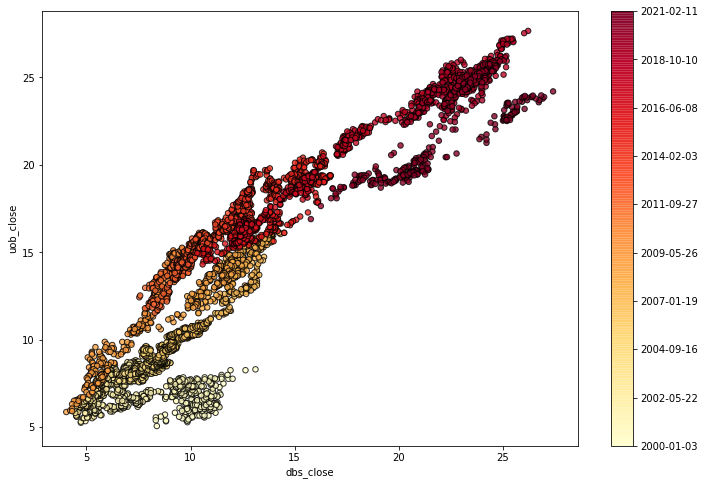

In [7]:
draw_date_coloured_scatterplot(['dbs_close','uob_close'], prices)

# System Noise Of The State/Transition Equation
<br></br>
<br></br>

For
\begin{eqnarray}
w_t &\sim& \mathcal{N} (0, W_t)
\end{eqnarray}
<br></br>
<br></br>

We need to specify a $\delta$ to control the $W_t$, transition covariance for the system noise.<br></br>
To get $W_t$, we multiple $\delta$ by the two-dimensional identity matrix.

In [8]:
# Specifing delta

delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)

# Creating An Observation Matrix

The observation matrix, $F_t$, is set to be $\begin{pmatrix} 1 \\ x_t \end{pmatrix}$

# Putting It Altogether

In [9]:
def calc_slope_intercept_kalman(stocks, prices):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    ETF prices.
    """
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [prices[stocks[0]], np.ones(prices[stocks[0]].shape)]
    ).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    state_means, state_covs = kf.filter(prices[stocks[1]].values)
    return state_means, state_covs

# DBS | UOB Specific Kalman Filter


## State Transition Equation 
\begin{eqnarray}
(\beta_0, \beta_1 )_t = G_t (\beta_0, \beta_1 )_{t-1} + w_t
\end{eqnarray}

## Observation Equation
\begin{eqnarray}
y_t &=& F_t {\bf x}_t + v_t \\
UOB_t &=& \begin{pmatrix} 1 \\ DBS_t \end{pmatrix} (\beta_0, \beta_1 ) + v_t
\end{eqnarray}

In [10]:
state_means, state_covs = calc_slope_intercept_kalman(['dbs_close', 'uob_close'], prices)

# Plotting the Dataframe

In [11]:
def draw_slope_intercept_changes(prices, state_means):
    """
    Plot the slope and intercept changes from the 
    Kalman Filte calculated values.
    """
    pd.DataFrame(
        dict(
            slope=state_means[:, 0], 
            intercept=state_means[:, 1]
        ), index=prices.index
    ).plot(subplots=True)
    plt.xticks(rotation=45)
    plt.show()

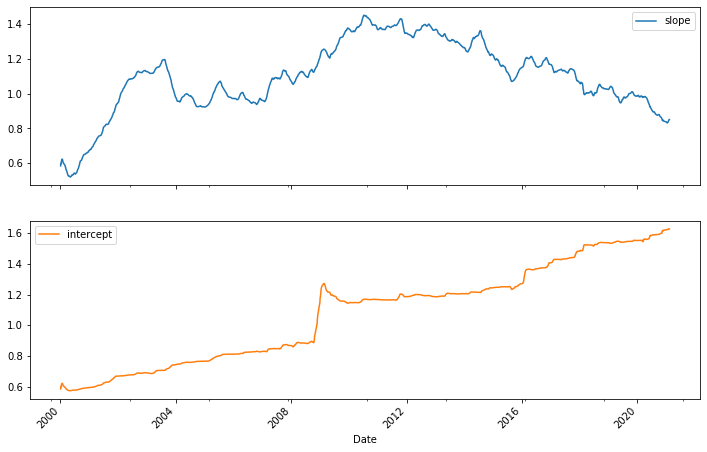

In [12]:
draw_slope_intercept_changes(prices, state_means)

# Estimating the Hedge Ratio using Linear Regression

In [13]:
reg = LinearRegression().fit(np.array(prices['dbs_close']).reshape(-1, 1), np.array(prices['uob_close']).reshape(-1,1))

In [14]:
reg.coef_

array([[0.98083156]])

# Creating Spread from Dynamic vs Static Ratios

In [15]:
dynamic_spread = prices['uob_close'] - state_means[:, 0]*prices['dbs_close']

In [16]:
static_spread = prices['uob_close'] - (np.ones(len(prices.index))*reg.coef_).squeeze()*prices['dbs_close']

# Static vs Dynamic Hedge Ratios

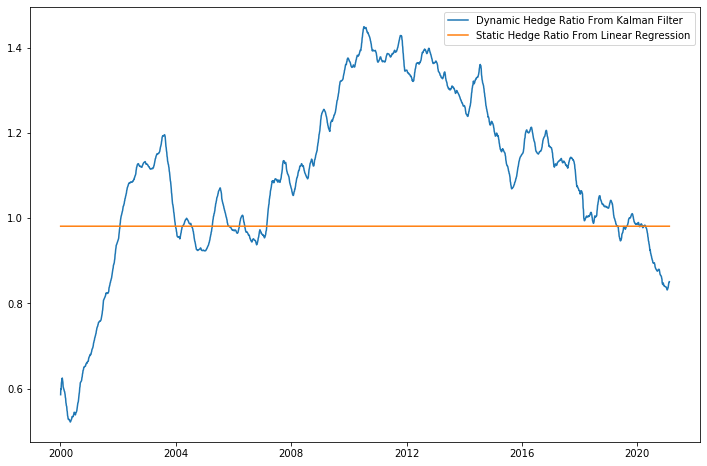

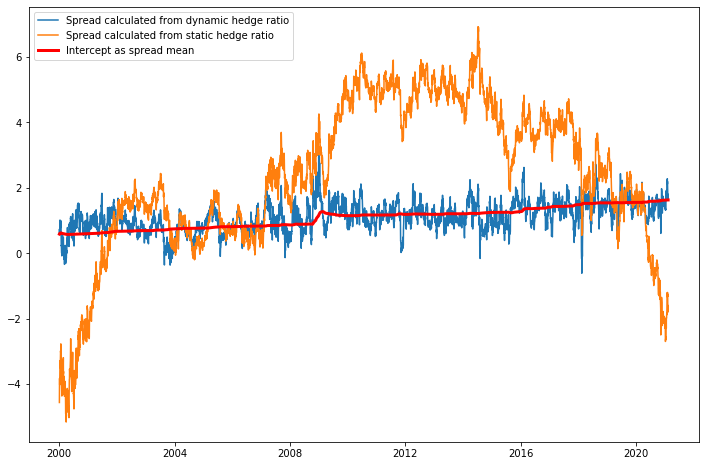

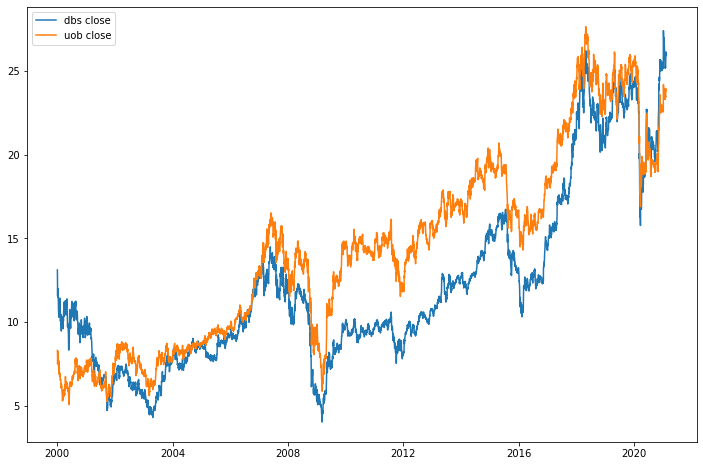

In [17]:
plt.plot(prices.index, state_means[:, 0], label='Dynamic Hedge Ratio From Kalman Filter')
plt.plot(prices.index, np.array(reg.coef_*np.ones(len(prices.index))).reshape(-1,1), label='Static Hedge Ratio From Linear Regression')
plt.legend()
plt.show()

plt.plot(prices.index, dynamic_spread, label='Spread calculated from dynamic hedge ratio')
plt.plot(prices.index, static_spread, label='Spread calculated from static hedge ratio')
plt.plot(prices.index, state_means[:, 1], label='Intercept as spread mean', color='red', linewidth=3)
plt.legend()
plt.show()

plt.plot(prices.index, prices['dbs_close'], label='dbs close')
plt.plot(prices.index, prices['uob_close'], label='uob close')
plt.legend()
plt.show()

# Trading With Kalman Filter

With $UOB_t$ as $y_t$ (observed), and $\begin{pmatrix} 1 \\ DBS_t \end{pmatrix}$ as the observation matrix
<br></br>
<br></br>
<br></br>
<br></br>
$(B_{0}, B_{1})_t$ is the kalman filter's estimated state.
<br></br>
<br></br>
<br></br>
<br></br>
Using $(B_0, B_1)_t$, we can produce a kalman filter's estimate of DBS via
\begin{eqnarray}
UOB_{predicted,t} = \begin{pmatrix} 1 \\ DBS_t \end{pmatrix}(\beta_0, \beta_1 )_{t}
\end{eqnarray}
<br></br>
<br></br>
<br></br>
<br></br>
We can thus observe an error, $e_t$
\begin{eqnarray}
e_{t} = UOB_t - UOB_{predicted,t}
\end{eqnarray}
<br></br>
<br></br>
<br></br>
<br></br>
Assuming that $\beta_{0t}$ is the moving average of the spread, this error, $e_t$ is none other than the deviation of the spread DBS-UOB from its predicted mean value, to see this, rearrange such that:
<br></br>
<br></br>
<br></br>
<br></br>
\begin{eqnarray}
UOB_{predicted,t} = \begin{pmatrix} 1 \\ DBS_t \end{pmatrix}(\beta_0, \beta_1 )_{t} \\ \\ 
e_{t} = UOB_t -  \begin{pmatrix} 1 \\ DBS_t \end{pmatrix}(\beta_0, \beta_1 )_{t} \\ \\
e_{t} = UOB_t - \beta_{1t}DBS_t  - \beta_{0t} \\ \\
e_{t} = Spread_t  - Spread_{ma} \\ \\
\end{eqnarray}

# Custom Kalman Filter As Implemented By Ernest P Chan


<br></br>
## State Transition Equation 
\begin{eqnarray}
(\beta_0, \beta_1 )_t = (\beta_0, \beta_1 )_{t-1} + w_t
\end{eqnarray}

## Observation Equation
\begin{eqnarray}
y_t &=& F_t {\bf x}_t + v_t \\
UOB_t &=& \begin{pmatrix} 1 \\ DBS_t \end{pmatrix} (\beta_0, \beta_1 ) + v_t
\end{eqnarray}

<br></br>
$y_t$ is the observed variable, the "explained" pair <br></br>
$f_t$ is the variable that is part of the observation matrix $F_t$

In [18]:
class KalmanFilterPairs():
    def __init__(self, y, f, delta, Ve):
        self.y = y # observed variable
        self.f = f # variable that is part of the observation matrix
        self.F = np.array(ts.add_constant(f))[:, [1, 0]] # observation matrix
        self.delta = delta # parameter that adjusts the sensitivity of the state update
        self.Ve = Ve # state noise variance
        
    def vectorised_filter(self):
        yhat = np.full(self.y.size, np.nan) # observed variable prediction
        e = yhat.copy() # error in observed variable prediction OR spread divergence
        Q = yhat.copy() # observed variable prediction variance OR spread divergence variance
        R = np.zeros((2,2)) # state error covariance
        P = R.copy() # state covariance update
        beta = np.full((2,self.f.size), np.nan) # state
        Vw = self.delta / (1 - self.delta) * np.eye(2) # observed variable noise variance

        beta[:, 0] = 0 # initialise beta to zero

        for t in range(self.y.size):
            if t > 0:
                beta[:, t] = beta[:, t-1] # state prediction
                R = P + Vw # state covariance prediction

            yhat[t] = np.dot(self.F[t, :], beta[:, t]) # observed variable prediction
            Q[t] = np.dot(np.dot(self.F[t, :], R), self.F[t, :].T) + self.Ve # observed variable variance prediction
            e[t] = self.y.iloc[t] - yhat[t] # observed variable prediction error

            K = np.dot(R, self.F[t, :].T) / Q[t] # Kalman gain
            beta[:, t] = beta[:, t] + np.dot(K, e[t]) # State update
            P = R - np.dot(np.outer(K, self.F[t, :]), R) # State covariance update

        # assigning
        self.mean = beta[1, :]
        self.hedge_ratio = beta[0, :]
        self.spread_divergence = e
        self.spread = self.spread_divergence + self.mean
        self.std = np.sqrt(Q)

In [124]:
kfp = KalmanFilterPairs(y=prices['uob_close'], 
                        f=prices['dbs_close'], 
                        delta=0.0001, 
                        Ve=0.1)

In [125]:
kfp.vectorised_filter()

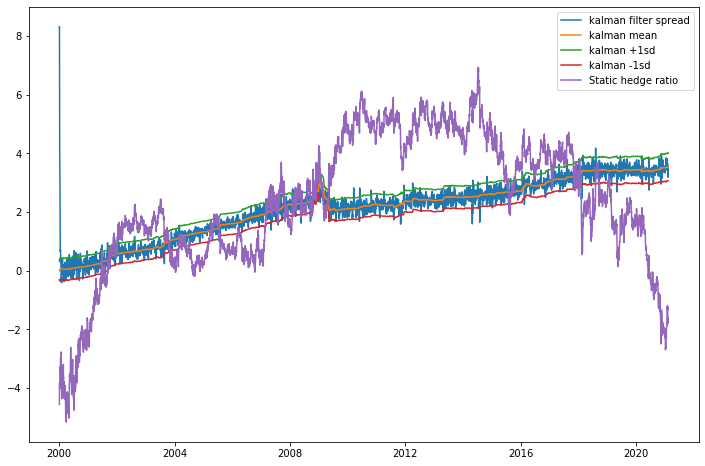

In [126]:
plt.plot(prices.index, kfp.spread, label='kalman filter spread')
plt.plot(prices.index, kfp.mean, label='kalman mean')
plt.plot(prices.index, kfp.mean+kfp.std, label='kalman +1sd')
plt.plot(prices.index, kfp.mean-kfp.std, label='kalman -1sd')

plt.plot(prices.index, static_spread, label='Static hedge ratio')
plt.legend()
plt.show()

# Backtesting the Kalman Filter

In [127]:
signals = pd.DataFrame({'kalman_spread': kfp.spread,
                        'kalman_mean': kfp.mean,
                        'kalman_std': kfp.std,
                        'uob_close': prices['uob_close'].values,
                        'dbs_close': prices['dbs_close'].values})

signals['+1sd'] = signals['kalman_mean'] + signals['kalman_std']
signals['-1sd'] = signals['kalman_mean'] - signals['kalman_std']

In [128]:
def update_cumulative_pos(signals, index):
    signals.loc[index, 'Σuob'] = signals.loc[index-1, 'Σuob'] + signals.loc[index, 'Δuob']
    signals.loc[index, 'Σdbs'] = signals.loc[index-1, 'Σdbs'] + signals.loc[index, 'Δdbs']
    
def keep_cumulative_pos(signals, index):
    signals.loc[index, 'Σuob'] = signals.loc[index-1, 'Σuob']
    signals.loc[index, 'Σdbs'] = signals.loc[index-1, 'Σdbs']

signals['Σuob'] = 0
signals['Δuob'] = 0
signals['Σdbs'] = 0
signals['Δdbs'] = 0

for index, signal in signals.iterrows():
    if index >= 100:
        exit_short = (signal['kalman_spread'] <= signal['kalman_mean']) and (signals.loc[index-1, 'Σuob'] <= -1)
        exit_long = (signal['kalman_spread'] >= signal['kalman_mean']) and (signals.loc[index-1, 'Σuob'] >= 1)
        enter_short = (signal['kalman_spread'] >= signal['+1sd']) and (signals.loc[index-1, 'Σuob'] == 0)
        enter_long = (signal['kalman_spread'] <= signal['-1sd']) and (signals.loc[index-1, 'Σuob'] == 0)
        
        net_short_uob = -1 - signals.loc[index-1, 'Σuob']
        net_long_uob = 1 - signals.loc[index-1, 'Σuob']
        net_short_dbs = -1 - signals.loc[index-1, 'Σdbs']
        net_long_dbs = 1 - signals.loc[index-1, 'Σdbs']
        exit_all_uob = -signals.loc[index-1, 'Σuob']
        exit_all_dbs = -signals.loc[index-1, 'Σdbs']
        
        # spread has crossed mean and was previous short
        if exit_short:
            signals.loc[index, 'Δuob'] = exit_all_uob # exit all positions
            signals.loc[index, 'Δdbs'] = exit_all_dbs # exit all positions
            update_cumulative_pos(signals, index)

        # spread has crossed mean and was previous long
        if exit_long:
            signals.loc[index, 'Δuob'] = exit_all_uob # exit all positions
            signals.loc[index, 'Δdbs'] = exit_all_dbs # exit all positions
            update_cumulative_pos(signals, index)

        # spread has crossed +1sd, no positions yet
        if enter_short:
            signals.loc[index, 'Δuob'] = net_short_uob
            signals.loc[index, 'Δdbs'] = net_long_dbs
            update_cumulative_pos(signals, index)

        # spread has crossed -1sd, no positions yet
        if enter_long:
            signals.loc[index, 'Δuob'] = net_long_uob
            signals.loc[index, 'Δdbs'] = net_short_dbs
            update_cumulative_pos(signals, index)
            
        if not (exit_short or exit_long or enter_short or enter_long):
            keep_cumulative_pos(signals, index)

In [129]:
signals.index = prices.index

In [130]:
non_empty_signals = signals[~((signals['Δdbs'] == 0) & (signals['Δuob'] == 0))]

In [131]:
# Custom backtester, using change in positions to calculate pnl
bt = BasicBacktester()

In [132]:
dbs_pnl = bt.single_asset_scorer(non_empty_signals, 'dbs', 1, 0)
uob_pnl = bt.single_asset_scorer(non_empty_signals, 'uob', 1, 0)
combined_pnl = dbs_pnl + uob_pnl

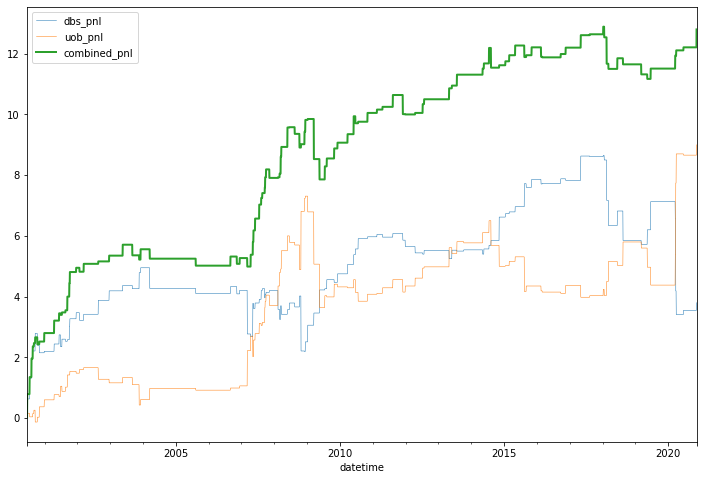

In [133]:
dbs_pnl['net_pnl'].cumsum().plot(label='dbs_pnl', linewidth=0.5)
uob_pnl['net_pnl'].cumsum().plot(label='uob_pnl', linewidth=0.5)
combined_pnl['net_pnl'].cumsum().plot(label='combined_pnl', linewidth=2)
plt.legend()
plt.show()

In [134]:
summary_statistics = bt.calculate_summary_statistics(combined_pnl)

In [135]:
summary_statistics

{'gross_pnl_mean': 0.0017,
 'net_pnl_mean': 0.0017,
 'gross_pnl_sum': 12.8,
 'net_pnl_sum': 12.8,
 'gain_to_pain': 2.3898,
 'adjusted_expectancy': 0.0052}